In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import streamlit as st

#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from google.cloud import storage
from IPython.display import Image
import os
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
import cv2
#from scipy import spatial

Don't run the below cell if you've already downloaded the images

In [ ]:
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= r"C:\Users\xin\OneDrive - Georgia Institute of Technology\6242CSE Data and Visual Analytics\Project\test\dataset\key3.json"
#client = storage.Client()
#bucket = client.get_bucket('dva_paintings')

In [2]:
paintings_df = pd.read_csv("cleaned_data_2.csv")
paintings_df.head(2)

,objectID,Title,ArtistName,Department,TimePeriod,Region,Height,Width,H/W Ratio,Color
0,35968,Forts Zeelandia and Provintia and the City of ...,Unidentified artist,Asian Art,19th century,China,3947,3059,1.290291,RGB
1,35970,Song of the Lute,Ding Yunpeng,Asian Art,1585,China,4000,3166,1.263424,RGB


In [3]:
df= paintings_df.copy()
#Time period in Century
#If a work spans more than one century, it will be put into both
#Ex: Chinese dynasties will go into all relevant century buckets
len(df['TimePeriod'].unique())

1056

In [4]:
#Various utility functions that I found useful while writing this code

#function, give objectID, get the index
def id_to_index(id_num):
    index = df.index[df['objectID'] == str(id_num)].tolist()
    return index[0]

#function, give index, get the objectID
def index_to_id(index):
    return df['objectID'][index]

#function, given id_number returns the file name
def id_to_file(id_num):
    file = 'dva_paintings/' + str(id_num) + '.jpg'
    return file
#print(id_to_file(437502))

## Model Traning on 2539 images
### if you only want to test, start from loading trained npy file and skip this part

In [5]:
#build a df of all names
path = 'dva_paintings/'

df_train = df[['objectID']]
df_train['filename'] = path + df_train['objectID'] + '.jpg'
del df_train['objectID']
df_train.head(2)

,filename
0,dva_paintings/35968.jpg
1,dva_paintings/35970.jpg


In [25]:
#df_train = df_train[:50]
df_train.shape

(2539, 1)

In [6]:
#Train a model
img_width, img_height = 224, 224
batch_size = 64

In [7]:
def extract_features_ResNet(dataframe, img_width=224, img_height=224, save=False):
    num_samples = len(dataframe)
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255,)
    model = ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_dataframe(
        dataframe,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode="rgb",
        shuffle=False,
        class_mode=None)

    for i in generator.filenames:
        #print(generator.filenames[:5])
        #print(i[(i.find("/")+1):i.find(".")])
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
        
    #extracted_features = model.fit(generator, num_samples // batch_size)
    extracted_features = model.predict(generator, num_samples // batch_size)
    extracted_features = extracted_features.reshape((num_samples, 100352)) 

    if save==True:
        np.save(open('ResNet_features.npy', 'wb'), extracted_features)
    #    np.save(open('ResNet_feature_object_ids.npy', 'wb'), np.array(Itemcodes))

    return extracted_features

In [28]:
#This cell make take a while
a = datetime.now()
ef = extract_features_ResNet(df_train,save=True)
print("Time taken in feature extraction", datetime.now()-a)
#ef for extracted features
ef.shape

94781440/94765736 [==============================] - 39s 0us/step
Found 2539 validated image filenames.
Time taken in feature extraction 2:25:00.288421


(2539, 100352)

In [8]:
def extract_features_VGG(dataframe, img_width=224, img_height=224, save=False):
    num_samples = len(dataframe)
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255,)
    model = VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_dataframe(
        dataframe,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode="rgb",
        shuffle=False,
        class_mode=None)

    for i in generator.filenames:
        #print(generator.filenames[:5])
        #print(i[(i.find("/")+1):i.find(".")])
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
        
    #extracted_features = model.fit(generator, num_samples // batch_size)
    extracted_features = model.predict(generator, num_samples // batch_size)
    extracted_features = extracted_features.reshape((num_samples, 25088)) 

    if save==True:
        np.save(open('VGG_features.npy', 'wb'), extracted_features)
    #    np.save(open('ResNet_feature_object_ids.npy', 'wb'), np.array(Itemcodes))

    return extracted_features

Be warned <span style="color:red">the next cell takes a very long time to run</span>.

In [ ]:
a = datetime.now()
ef_vgg = extract_features_VGG(df_train,save=True)
print("Time taken in feature extraction", datetime.now()-a)
#ef for extracted features
ef_vgg.shape

In [9]:
base_model = VGG16(weights='imagenet')
model = Model(inputs = base_model.input, outputs=base_model.get_layer("block4_pool").output)

def extract_features_customized(dataframe, img_width=224, img_height=224, save=False):
    num_samples = len(dataframe)
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=0.35,
                                width_shift_range=0.2,
                                height_shift_range=0.2)
    
    generator = datagen.flow_from_dataframe(
        dataframe,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode="rgb",
        shuffle=False,
        class_mode=None)

    for i in generator.filenames:
        #print(generator.filenames[:5])
        #print(i[(i.find("/")+1):i.find(".")])
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
        
    #extracted_features = model.fit(generator, num_samples // batch_size)
    extracted_features = model.predict(generator, num_samples // batch_size)
    extracted_features = extracted_features.reshape((num_samples, 14*14*512)) 

    if save==True:
        np.save(open('Customized_features.npy', 'wb'), extracted_features)
    #    np.save(open('ResNet_feature_object_ids.npy', 'wb'), np.array(Itemcodes))

    return extracted_features

In [ ]:
a = datetime.now()
ef_cust = extract_features_customized(df_train,save=True)
print("Time taken in feature extraction", datetime.now()-a)
#ef for extracted features
ef_cust.shape

In [ ]:
#Apply training to a new datapoint

In [10]:
def new_image_as_df(new_image):
    new_image = 'dva_paintings/' + str(new_image) + '.jpg'

    new_df = pd.DataFrame()
    new_df['filename'] = [new_image]
    return new_df

### Load the trained npy file

In [11]:
#To save time, you can also load the data if you stored from the extract_feature function
ef = np.load('ResNet_features.npy')
ef_vgg = np.load('VGG_features.npy')
ef_cust = np.load('Customized_features.npy')
print(ef.shape)
print(ef_vgg.shape)
print(ef_cust.shape)

(2539, 100352)
(2539, 25088)
(2539, 100352)


In [12]:
test_df_1 = new_image_as_df(37961)
ef_test_res = extract_features_ResNet(test_df_1)
ef_test_vgg = extract_features_VGG(test_df_1)
ef_test_cust = extract_features_customized(test_df_1)
print(ef_test_res.shape)
print(ef_test_vgg.shape)
print(ef_test_cust.shape)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
(1, 100352)
(1, 25088)
(1, 100352)


In [18]:
from PIL import Image
def show_image(id_num):
    file = id_to_file(id_num)
    im = Image.open(file)
    im = im.resize((100,100)) #resizing is much faster
    display(im)
#show_image(36020)

In [13]:
def getCosineSimilarity(A, B):
    cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
    return cos_similarity[0][0]

In [14]:
#find similar images
def get_similar_art(extracted_features, new_art_ef, id_num, count=5,distance = "euclidean"):

    #Enter a dataframe and the ID number for image in the set
    if distance == "euclidean":
        dist = pairwise_distances(extracted_features, new_art_ef).T[0]
        indices = np.argsort(dist)[0:count]
        pdists  = np.sort(dist)[0:count]
    elif distance == "cosine":
        dist = []
        for feature in extracted_features:
            dist.append(getCosineSimilarity(feature.reshape(1,extracted_features.shape[1]), new_art_ef))
        indices = np.argsort(dist)[0:count]
        pdists  = np.sort(dist)[0:count]
    
    elif distance == "rmse":
        dist = []
        for feature in extracted_features:
            dist.append(rmse(feature.reshape(1,extracted_features.shape[1]), new_art_ef))
        indices = np.argsort(dist)[0:count]
        pdists  = np.sort(dist)[0:count]
    
  
    min_elements =  np.array(dist)[indices]
    
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]

    print("="*20, "input product image", "="*20)
    show_image(id_num)
    mylist = []

    print("\n","="*20, "Similar Images", "="*20)
    i=-1
    for index in ordered_indices:
        i+=1
        objectID = index_to_id(index)
        mylist.append(objectID)
        show_image(objectID)
        print('Distance from input image:', pdists[i])
    #return and display
    return mylist, ordered_indices

In [15]:
def get_image(id_num):
    file = id_to_file(id_num)
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100,100))
    #im = im.resize((100,100)) #resizing is much faster
    return img

## Testing

In [48]:
test_list = [37961,40011,435595,435687]
new_image = test_list[3]
new_image_df_test = new_image_as_df(new_image)
test_df_1 = new_image_as_df(new_image)
ef_test_res = extract_features_ResNet(test_df_1)
ef_test_vgg = extract_features_VGG(test_df_1)
ef_test_cust = extract_features_customized(test_df_1)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.


### ResNet50

==================== input product image ====================


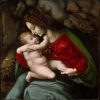


 ==================== Similar Images ====================


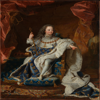

Distance from input image: 28.784243


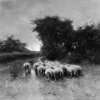

Distance from input image: 30.362549


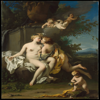

Distance from input image: 30.505001


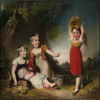

Distance from input image: 30.754368


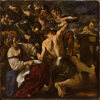

Distance from input image: 31.716917
['437464', '437044', '435573', '437239', '436603']
[2025 1785  994 1878 1555]
avg mse:  68.90758366625977
avg mse:  (0.15253815021947292+0j)
0:00:42.265464


,id,mse,rmse,scc,uqi,msssim,vifp
0,437464,3604.249700,60.035404,-0.002998,0.491516,0.181052+0.000000j,0.007000
1,437044,10181.884000,100.905322,0.006638,0.392313,0.232221+0.000000j,0.012219
2,435573,3472.746633,58.930015,0.009077,0.529678,0.156053+0.000000j,0.006696
3,437239,4089.825967,63.951747,-0.006915,0.524241,0.107353+0.000000j,0.008279
4,436603,3686.363533,60.715431,0.036484,0.471770,0.086011+0.000000j,0.006975


In [40]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef, ef_test_res, id_num=new_image,distance = "euclidean")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_res_euclidean = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_res_euclidean["id"].append(mylist[i])
    similarity_res_euclidean["mse"].append(mse(new_art,similar_art))
    similarity_res_euclidean["rmse"].append(rmse(new_art,similar_art))
    similarity_res_euclidean["scc"].append(scc(new_art,similar_art))
    similarity_res_euclidean["uqi"].append(uqi(new_art,similar_art))
    similarity_res_euclidean["msssim"].append(msssim(new_art,similar_art))
    similarity_res_euclidean["vifp"].append(vifp(new_art,similar_art))
#mse: calculates mean squared error, smaller means more similar
#rmse: calculates root mean squared error, smaller means more similar
#scc: calculates spatial correlation coefficient
#uqi: calculates universal image quality index
#msssim: calculates multi-scale structural similarity index
#vifp: calculates Pixel Based Visual Information Fidelity
similarity_res_euclidean_df = pd.DataFrame(similarity_res_euclidean)  
print("avg mse: ", np.mean(similarity_res_euclidean_df["rmse"]))
print("avg mse: ", np.mean(similarity_res_euclidean_df["msssim"]))
similarity_res_euclidean_df
print(datetime.now()-a)
similarity_res_euclidean_df
# id 36109 has the smallest mse, rmse, highest uqi, msssim

==================== input product image ====================


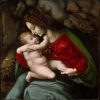


 ==================== Similar Images ====================


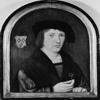

Distance from input image: 0.93610495


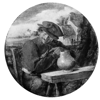

Distance from input image: 0.9409189


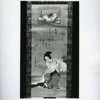

Distance from input image: 0.9422464


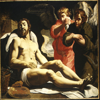

Distance from input image: 0.94394124


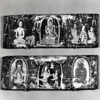

Distance from input image: 0.9477676
['437210', '435805', '48898', '436776', '37793']
[1862 1106  418 1638   66]
avg mse:  118.00826773526595
avg msssim:  (0.057472479615606434+0.03057610627508713j)
0:00:12.038196


,id,mse,rmse,scc,uqi,msssim,vifp
0,437210,9915.870200,99.578463,0.001994,0.339224,-0.004682+0.040764j,0.006094
1,435805,21769.688600,147.545548,0.002316,0.321458,-0.004736+0.041237j,0.004719
2,48898,22093.122167,148.637553,-0.007367,0.321032,0.046544+0.042701j,0.007871
3,436776,6209.447167,78.800045,-0.003422,0.497036,0.253473+0.000000j,0.013737
4,37793,13335.568067,115.479730,-0.001651,0.343742,-0.003237+0.028179j,0.004671


In [41]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef, ef_test_res, id_num=new_image,distance = "cosine")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_res_cos = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_res_cos["id"].append(mylist[i])
    similarity_res_cos["mse"].append(mse(new_art,similar_art))
    similarity_res_cos["rmse"].append(rmse(new_art,similar_art))
    similarity_res_cos["scc"].append(scc(new_art,similar_art))
    similarity_res_cos["uqi"].append(uqi(new_art,similar_art))
    similarity_res_cos["msssim"].append(msssim(new_art,similar_art))
    similarity_res_cos["vifp"].append(vifp(new_art,similar_art))
similarity_res_cos_df = pd.DataFrame(similarity_res_cos)  
print("avg mse: ", np.mean(similarity_res_cos_df["rmse"]))
print("avg msssim: ", np.mean(similarity_res_cos_df["msssim"]))
print(datetime.now()-a)
similarity_res_cos_df

In [ ]:
mylist, ordered_indices = get_similar_art(ef, ef_test_res, id_num=new_image,distance = "rmse")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_res_mse = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_res_mse["id"].append(mylist[i])
    similarity_res_mse["mse"].append(mse(new_art,similar_art))
    similarity_res_mse["rmse"].append(rmse(new_art,similar_art))
    similarity_res_mse["scc"].append(scc(new_art,similar_art))
    similarity_res_mse["uqi"].append(uqi(new_art,similar_art))
    similarity_res_mse["msssim"].append(msssim(new_art,similar_art))
    similarity_res_mse["vifp"].append(vifp(new_art,similar_art))
similarity_res_mse_df = pd.DataFrame(similarity_res_mse)  
print("avg mse: ", np.mean(similarity_res_mse_df["mse"]))
similarity_res_mse_df

## VGG16

==================== input product image ====================


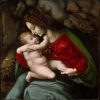


 ==================== Similar Images ====================


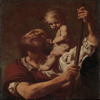

Distance from input image: 38.819546


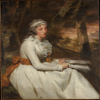

Distance from input image: 39.411896


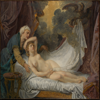

Distance from input image: 39.681095


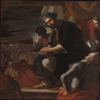

Distance from input image: 39.824844


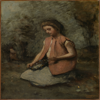

Distance from input image: 39.845634
['437281', '437361', '436580', '437333', '435971']
[1901 1948 1540 1932 1206]
avg mse:  59.07344304159344
avg msssim:  (0.1370427566994689+0.016893930602012896j)
0:00:23.459964


,id,mse,rmse,scc,uqi,msssim,vifp
0,437281,2951.885333,54.331256,-0.001728,0.556910,0.110363+0.000000j,0.007670
1,437361,5091.695433,71.356117,0.008537,0.556589,0.245495+0.000000j,0.011684
2,436580,3770.021167,61.400498,-0.006913,0.540712,0.174477+0.000000j,0.007938
3,437333,2919.594700,54.033274,-0.000142,0.535044,0.062806+0.000000j,0.005505
4,435971,2942.636167,54.246071,0.007123,0.537997,0.092073+0.084470j,0.007766


In [42]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef_vgg, ef_test_vgg, id_num=new_image,distance="euclidean")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_vgg_euclidean = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_vgg_euclidean["id"].append(mylist[i])
    similarity_vgg_euclidean["mse"].append(mse(new_art,similar_art))
    similarity_vgg_euclidean["rmse"].append(rmse(new_art,similar_art))
    similarity_vgg_euclidean["scc"].append(scc(new_art,similar_art))
    similarity_vgg_euclidean["uqi"].append(uqi(new_art,similar_art))
    similarity_vgg_euclidean["msssim"].append(msssim(new_art,similar_art))
    similarity_vgg_euclidean["vifp"].append(vifp(new_art,similar_art))
similarity_vgg_euclidean_df = pd.DataFrame(similarity_vgg_euclidean) 
print("avg mse: ", np.mean(similarity_vgg_euclidean_df["rmse"]))
print("avg msssim: ", np.mean(similarity_vgg_euclidean_df["msssim"]))
print(datetime.now()-a)
similarity_vgg_euclidean_df

==================== input product image ====================


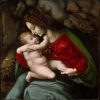


 ==================== Similar Images ====================


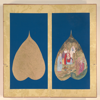

Distance from input image: 0.7301137


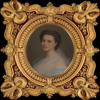

Distance from input image: 0.7444479


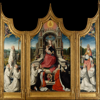

Distance from input image: 0.7558632


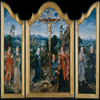

Distance from input image: 0.7645733


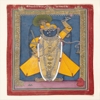

Distance from input image: 0.76696783
['38822', '441111', '435638', '436792', '72719']
[ 127 2447 1027 1645  901]
avg rmse:  101.76012133601594
avg msssim:  (0.05682099921578+0.027444977630282287j)
0:00:12.948571


,id,mse,rmse,scc,uqi,msssim,vifp
0,38822,13392.545967,115.726168,-0.013493,0.362733,0.206051+0.000000j,0.009388
1,441111,7483.021800,86.504461,0.000284,0.389745,-0.009767+0.085041j,0.006199
2,435638,7881.511400,88.777877,0.017131,0.313334,0.019735+0.027181j,0.004004
3,436792,8026.077933,89.588381,-0.007453,0.376525,-0.002872+0.025003j,0.006000
4,72719,16436.193867,128.203720,0.004952,0.351937,0.070958+0.000000j,0.006385


In [44]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef_vgg, ef_test_vgg, id_num=new_image,distance="cosine")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_vgg_cosine = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_vgg_cosine["id"].append(mylist[i])
    similarity_vgg_cosine["mse"].append(mse(new_art,similar_art))
    similarity_vgg_cosine["rmse"].append(rmse(new_art,similar_art))
    similarity_vgg_cosine["scc"].append(scc(new_art,similar_art))
    similarity_vgg_cosine["uqi"].append(uqi(new_art,similar_art))
    similarity_vgg_cosine["msssim"].append(msssim(new_art,similar_art))
    similarity_vgg_cosine["vifp"].append(vifp(new_art,similar_art))
similarity_vgg_cosine_df = pd.DataFrame(similarity_vgg_cosine)  
print("avg rmse: ", np.mean(similarity_vgg_cosine_df["rmse"]))
print("avg msssim: ", np.mean(similarity_vgg_cosine_df["msssim"]))
print(datetime.now()-a)
similarity_vgg_cosine_df

==================== input product image ====================


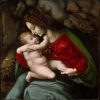


 ==================== Similar Images ====================


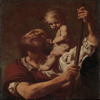

Distance from input image: 0.24508539954217898


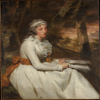

Distance from input image: 0.24882516146658606


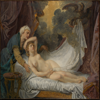

Distance from input image: 0.25052473936367553


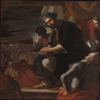

Distance from input image: 0.25143230122655313


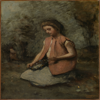

Distance from input image: 0.25156354104247686
['437281', '437361', '436580', '437333', '435971']
[1901 1948 1540 1932 1206]
avg rmse:  59.07344304159344
avg msssim:  (0.16420865337997625+0j)
0:00:15.997745


In [43]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef_vgg, ef_test_vgg, id_num=new_image,distance="rmse")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_vgg_rmse = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_vgg_rmse["id"].append(mylist[i])
    similarity_vgg_rmse["mse"].append(mse(new_art,similar_art))
    similarity_vgg_rmse["rmse"].append(rmse(new_art,similar_art))
    similarity_vgg_rmse["scc"].append(scc(new_art,similar_art))
    similarity_vgg_rmse["uqi"].append(uqi(new_art,similar_art))
    similarity_vgg_rmse["msssim"].append(msssim(new_art,similar_art))
    similarity_vgg_rmse["vifp"].append(vifp(new_art,similar_art))
similarity_vgg_rmse_df = pd.DataFrame(similarity_vgg_rmse)  
print("avg rmse: ", np.mean(similarity_vgg_rmse_df["rmse"]))
print("avg msssim: ", np.mean(similarity_cust_euclidean_df["msssim"]))
similarity_vgg_rmse_df
print(datetime.now()-a)

## Customized nneural network

==================== input product image ====================


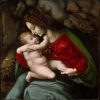


 ==================== Similar Images ====================


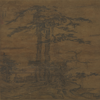

Distance from input image: 503.06973


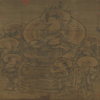

Distance from input image: 505.61472


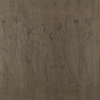

Distance from input image: 507.7992


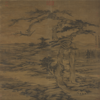

Distance from input image: 509.20737


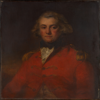

Distance from input image: 509.9816
['TP_04009150', 'TP_04009147', '51526', 'TP_04000976', '436684']
[2534 2531  533 2495 1602]
0:00:51.963561
avg rmse:  58.06272655488421
avg msssim:  (0.044002502770824126+0.02017901838486838j)


,id,mse,rmse,scc,uqi,msssim,vifp
0,TP_04009150,3126.709733,55.916990,-0.008274,0.509212,0.014939+0.013706j,0.002593
1,TP_04009147,3454.522333,58.775185,-0.000137,0.496656,0.057162+0.000000j,0.002912
2,51526,3996.927400,63.221258,-0.031280,0.481981,0.052874+0.000000j,0.002329
3,TP_04000976,3647.601500,60.395376,-0.006947,0.493713,0.051262+0.047029j,0.003625
4,436684,2704.501767,52.004824,0.010739,0.540973,0.043775+0.040161j,0.004272


In [45]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef_cust, ef_test_cust, id_num=new_image,distance = "euclidean")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_cust_euclidean = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_cust_euclidean["id"].append(mylist[i])
    similarity_cust_euclidean["mse"].append(mse(new_art,similar_art))
    similarity_cust_euclidean["rmse"].append(rmse(new_art,similar_art))
    similarity_cust_euclidean["scc"].append(scc(new_art,similar_art))
    similarity_cust_euclidean["uqi"].append(uqi(new_art,similar_art))
    similarity_cust_euclidean["msssim"].append(msssim(new_art,similar_art))
    similarity_cust_euclidean["vifp"].append(vifp(new_art,similar_art))
similarity_cust_euclidean_df = pd.DataFrame(similarity_cust_euclidean)  
print(datetime.now()-a)
print("avg rmse: ", np.mean(similarity_cust_euclidean_df["rmse"]))
print("avg msssim: ", np.mean(similarity_cust_euclidean_df["msssim"]))
similarity_cust_euclidean_df

==================== input product image ====================


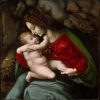


 ==================== Similar Images ====================


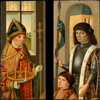

Distance from input image: 0.26320794


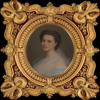

Distance from input image: 0.26347375


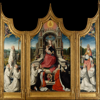

Distance from input image: 0.2668153


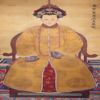

Distance from input image: 0.2701607


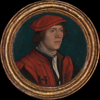

Distance from input image: 0.27029198
['437199', '441111', '435638', '53528', '436660']
[1857 2447 1027  685 1587]
0:00:14.088594
avg rmse:  88.68017108814381
avg msssim:  (0.037105133907256935+0.043839078562902534j)


,id,mse,rmse,scc,uqi,msssim,vifp
0,437199,8298.033733,91.093544,-0.001784,0.334870,0.058956+0.000000j,0.006601
1,441111,7483.021800,86.504461,0.000284,0.389745,-0.009767+0.085041j,0.006199
2,435638,7881.511400,88.777877,0.017131,0.313334,0.019735+0.027181j,0.004004
3,53528,12131.126667,110.141394,0.002376,0.360788,0.065003+0.059635j,0.006074
4,436660,4473.413233,66.883580,0.007360,0.379073,0.051599+0.047338j,0.005439


In [46]:
a = datetime.now()
mylist, ordered_indices = get_similar_art(ef_cust, ef_test_cust, id_num=new_image,distance = "cosine")
print(mylist)
print(ordered_indices)

new_art = get_image(new_image)
similarity_cust_cos = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_cust_cos["id"].append(mylist[i])
    similarity_cust_cos["mse"].append(mse(new_art,similar_art))
    similarity_cust_cos["rmse"].append(rmse(new_art,similar_art))
    similarity_cust_cos["scc"].append(scc(new_art,similar_art))
    similarity_cust_cos["uqi"].append(uqi(new_art,similar_art))
    similarity_cust_cos["msssim"].append(msssim(new_art,similar_art))
    similarity_cust_cos["vifp"].append(vifp(new_art,similar_art))
similarity_cust_cos_df = pd.DataFrame(similarity_cust_cos)  
print(datetime.now()-a)

print("avg rmse: ", np.mean(similarity_cust_cos_df["rmse"]))
print("avg msssim: ", np.mean(similarity_cust_cos_df["msssim"]))
similarity_cust_cos_df

## What if compare images without feature extraction?

==================== input product image ====================


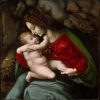


 ==================== Similar Images ====================


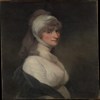

rmse Distance from input image: 47.83393147128929


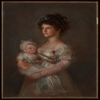

rmse Distance from input image: 48.27973798603303


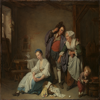

rmse Distance from input image: 49.23299774202935


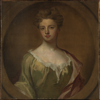

rmse Distance from input image: 49.24604451120922


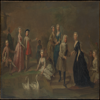

rmse Distance from input image: 49.83016522816944
avg rmse:  48.88457538774607
avg rmse:  (0.2042667462219761+0j)
0:30:38.058567


,id,mse,rmse,scc,uqi,msssim,vifp
0,436688,2288.085000,47.833931,-0.004320,0.588883,0.274840+0.000000j,0.013719
1,436550,2330.933100,48.279738,0.013463,0.603840,0.207394+0.000000j,0.007715
2,436579,2423.888067,49.232998,0.004875,0.596039,0.264672+0.000000j,0.014221
3,436824,2425.172900,49.246045,-0.016697,0.600171,0.140988+0.000000j,0.007868
4,436079,2483.045367,49.830165,-0.000767,0.559497,0.133440+0.000000j,0.007034


In [47]:


test_id = get_image(new_image)
train_id = df['objectID'].tolist()
def get_similar_art_pure_rmse(train_id, test_id, id_num, count=5):

    #Enter a dataframe and the ID number for image in the set
    
    dist = []
    for t in train_id:
        t_resize = get_image(t)
        dist.append(rmse(t_resize,test_id))
   
    indices = np.argsort(dist)[0:count]
    pdists  = np.sort(dist)[0:count]
    min_elements = np.array(dist)[indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    print("="*20, "input product image", "="*20)
    show_image(new_image)
    mylist = []
    print("\n","="*20, "Similar Images", "="*20)
    i=-1
    for index in ordered_indices:
        i+=1
        objectID = index_to_id(index)
        mylist.append(objectID)
        show_image(objectID)
        print('rmse Distance from input image:', pdists[i])
    return mylist, ordered_indices

a = datetime.now()
mylist, ordered_indices = get_similar_art_pure_rmse(train_id, test_id, id_num=new_image, count=5)
new_art = get_image(new_image)
similarity_direct_euclidean = {"id":[],'mse': [], 'rmse': [],"scc":[],"uqi":[],"msssim":[],"vifp":[]}  
for i in range(5):
    similar_art = get_image(mylist[i])
    similarity_direct_euclidean["id"].append(mylist[i])
    similarity_direct_euclidean["mse"].append(mse(new_art,similar_art))
    similarity_direct_euclidean["rmse"].append(rmse(new_art,similar_art))
    similarity_direct_euclidean["scc"].append(scc(new_art,similar_art))
    similarity_direct_euclidean["uqi"].append(uqi(new_art,similar_art))
    similarity_direct_euclidean["msssim"].append(msssim(new_art,similar_art))
    similarity_direct_euclidean["vifp"].append(vifp(new_art,similar_art))
similarity_direct_euclidean_df = pd.DataFrame(similarity_direct_euclidean)  
print("avg rmse: ", np.mean(similarity_direct_euclidean_df["rmse"]))
print("avg rmse: ", np.mean(similarity_direct_euclidean_df["msssim"]))
print(datetime.now()-a)
similarity_direct_euclidean_df

In [35]:


test_id = get_image(37961)
train_id = df['objectID'].tolist()
def get_similar_art_pure_cosine(train_id, test_id, id_num, count=5):

    #Enter a dataframe and the ID number for image in the set
    test_array = test_id.flatten()
    dist = []
    for t in train_id:
        t_resize = get_image(t)
        train_array = t_resize.flatten()
        similarity = -1 * (spatial.distance.cosine(train_array, test_array) - 1)
        dist.append(similarity)
   
    indices = np.argsort(dist)[0:count]
    pdists  = np.sort(dist)[0:count]
    min_elements = np.array(dist)[indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    print("="*20, "input product image", "="*20)
    show_image(id_num)
    mylist = []
    print("\n","="*20, "Similar Images", "="*20)
    i=-1
    for index in ordered_indices:
        i+=1
        objectID = index_to_id(index)
        mylist.append(objectID)
        show_image(objectID)
        print('rmse Distance from input image:', pdists[i])
    return mylist, ordered_indices
get_similar_art_pure_cosine(train_id, test_id, 37961, count=5)

==================== input product image ====================


AttributeError: type object 'Image' has no attribute 'open'

In [ ]:
import phasepack.phasecong as pc
def fsim( org_img, pred_img, T1: float = 0.85, T2: float = 160):
    """
    Feature-based similarity index, based on phase congruency (PC) and image gradient magnitude (GM)
    There are different ways to implement PC, the authors of the original FSIM paper use the method
    defined by Kovesi (1999). The Python phasepack project fortunately provides an implementation
    of the approach.
    There are also alternatives to implement GM, the FSIM authors suggest to use the Scharr
    operation which is implemented in OpenCV.
    Note that FSIM is defined in the original papers for grayscale as well as for RGB images. Our use cases
    are mostly multi-band images e.g. RGB + NIR. To accommodate for this fact, we compute FSIM for each individual
    band and then take the average.
    Note also that T1 and T2 are constants depending on the dynamic range of PC/GM values. In theory this parameters
    would benefit from fine-tuning based on the used data, we use the values found in the original paper as defaults.
    Args:
        org_img -- numpy array containing the original image
        pred_img -- predicted image
        T1 -- constant based on the dynamic range of PC values
        T2 -- constant based on the dynamic range of GM values
    """
    
    alpha = (beta) = 1  # parameters used to adjust the relative importance of PC and GM features
    fsim_list = []
    for i in range(org_img.shape[2]):
        # Calculate the PC for original and predicted images
        pc1_2dim = pc(
            org_img[:, :, i], nscale=4, minWaveLength=6, mult=2, sigmaOnf=0.5978
        )
        pc2_2dim = pc(
            pred_img[:, :, i], nscale=4, minWaveLength=6, mult=2, sigmaOnf=0.5978
        )

        # pc1_2dim and pc2_2dim are tuples with the length 7, we only need the 4th element which is the PC.
        # The PC itself is a list with the size of 6 (number of orientation). Therefore, we need to
        # calculate the sum of all these 6 arrays.
        pc1_2dim_sum = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.float64)
        pc2_2dim_sum = np.zeros(
            (pred_img.shape[0], pred_img.shape[1]), dtype=np.float64
        )
        for orientation in range(6):
            pc1_2dim_sum += pc1_2dim[4][orientation]
            pc2_2dim_sum += pc2_2dim[4][orientation]

        # Calculate GM for original and predicted images based on Scharr operator
        gm1 = _gradient_magnitude(org_img[:, :, i], cv2.CV_16U)
        gm2 = _gradient_magnitude(pred_img[:, :, i], cv2.CV_16U)

        # Calculate similarity measure for PC1 and PC2
        S_pc = _similarity_measure(pc1_2dim_sum, pc2_2dim_sum, T1)
        # Calculate similarity measure for GM1 and GM2
        S_g = _similarity_measure(gm1, gm2, T2)

        S_l = (S_pc ** alpha) * (S_g ** beta)

        numerator = np.sum(S_l * np.maximum(pc1_2dim_sum, pc2_2dim_sum))
        denominator = np.sum(np.maximum(pc1_2dim_sum, pc2_2dim_sum))
        fsim_list.append(numerator / denominator)

    return np.mean(fsim_list)
def _gradient_magnitude(img: np.ndarray, img_depth: int):
    """
    Calculate gradient magnitude based on Scharr operator.
    """
    scharrx = cv2.Scharr(img, img_depth, 1, 0)
    scharry = cv2.Scharr(img, img_depth, 0, 1)

    return np.sqrt(scharrx ** 2 + scharry ** 2)
def _similarity_measure(x: np.array, y: np.array, constant: float):
    """
    Calculate feature similarity measurement between two images
    """
    numerator = 2 * x * y + constant
    denominator = x ** 2 + y ** 2 + constant

    return numerator / denominator

In [ ]:
def get_similar_art_fsim(train_id, test_id, id_num, count=5):

    #Enter a dataframe and the ID number for image in the set
    
    dist = []
    for t in train_id:
        t_resize = get_image(t)
        dist.append(fsim(t_resize,test_id))
   
    indices = np.argsort(dist)[0:count]
    pdists  = np.sort(dist)[0:count]
    min_elements = np.array(dist)[indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    print("="*20, "input product image", "="*20)
    show_image(37961)
    mylist = []
    print("\n","="*20, "Similar Images", "="*20)
    i=-1
    for index in ordered_indices:
        i+=1
        objectID = index_to_id(index)
        mylist.append(objectID)
        show_image(objectID)
        print('vifp Distance from input image:', pdists[i])
    return mylist, ordered_indices

In [ ]:
a = datetime.now()
get_similar_art_fsim(train_id,test_id,37961)
print(datetime.now()-a)

In [ ]:
throw and error here

In [ ]:
# https://keras.io/api/applications/
# https://www4.comp.polyu.edu.hk/~cslzhang/IQA/TIP_IQA_FSIM.pdf